In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scsavailability as scs
    
import statsmodels.api as sm
from scipy import stats

from scsavailability import features as feat, model as md, plotting as pt, score as sc

2020-12-22 13:13:39,990 - NumExpr defaulting to 8 threads.


In [4]:
path = 'C:/Users/Jamie.williams/OneDrive - Newton Europe Ltd/Castle Donnington/Data/'

In [6]:
at = pd.read_csv(path+'active_totes_20201210.csv')
av = pd.read_csv(path+'Availability_with_Grey&Blue_1811-0912.csv',names = ["timestamp","Pick Station","Availability","Blue Tote Loss","Grey Tote Loss"])
#fa = pd.read_csv(path + 'scs_tote_matched.csv')
scs_raw = pd.read_csv(path + 'Faults20_11-10_12.csv')

In [7]:
fa = feat.add_code(scs_raw)
fa, unmapped = feat.add_tote_colour(fa)

Running: Function "load_tote_lookup" (id=2123904880064) was called 1 times


In [8]:
at = feat.pre_process_AT(at_raw)

Running: Function "pre_process_AT" (id=2123904879344) was called 1 times


In [9]:
av = feat.pre_process_av(av)

Running: Function "pre_process_av" (id=2123904880496) was called 1 times


In [10]:
fa = feat.preprocess_faults(fa,remove_same_location_faults = True)

Running: Function "preprocess_faults" (id=2123904879488) was called 1 times
Running: Function "load_module_lookup" (id=2123904879776) was called 1 times
Running: Function "load_ID_lookup" (id=2123904880208) was called 1 times
duplicated location faults removed - max duration kept
HOTFIX: Quadrant only faults, PTT Asset Code update


In [131]:
fa_floor = feat.floor_shift_time_fa(fa, shift=20)
fa_sel = feat.fault_select(fa_floor, fault_select_options = {'Tote Colour':['Both','Blue','Grey']},duration_thres = 1)

Time shifted by 20Minutes


In [141]:
def run_m(module, fa_floor, av, at):
    """
    Summary
    -------
    Runs model-level linear model and outputs the "significant" asset codes and their coefficients.
    1. Select Module-related faults
    2. Filter out rare asset codes
    3. Fit Model
    4. Remove high p-values
    5. Re-fit model
    6. Report negative coefficients
    ----------
    module: int
        module number
    fa_floor: pandas DataFrame
        formatted faults data
    av: pandas DataFrame
        formatted availability data
    at: pandas DataFrame
        formatted active totes data
    Returns
    -------
    df_r: pandas DataFrame
        significant coefficients
    Example
    --------
    df_r = run_m(2, fa_floor, av, at)
    """
    
    mod = [str(module)]
    
    
    fa_sel_1 = feat.get_data_faults(fa_floor, modules = mod)
    limit = 250
    most_common = list(((fa_sel_1['Asset Code'].value_counts() > limit)[fa_sel_1['Asset Code'].value_counts() > limit]).index)
    fa_sel = fa_sel_1[fa_sel_1['Asset Code'].isin(most_common)]


    fa_agg = feat.faults_aggregate(fa_sel, fault_agg_level= 'Asset Code', agg_type = 'count')

    av_sel, at_sel = feat.av_at_select(av, at, remove_high_AT = True, availability_select_options = {"Module" : mod})

    av_agg = feat.aggregate_availability(av_sel, agg_level = 'Module')
    at_agg = feat.aggregate_totes(at_sel, agg_level = 'Module')

    df = feat.merge_av_fa_at(av_agg ,at_df=at_agg, fa_df = fa_agg, agg_level = 'None')
    X,y = md.gen_feat_var(df, features = ['Totes','Faults'])
    #X = X.drop('Module', axis=1)
    # Flip to availability
    y=1-y
  

    X_train, X_test, y_train, y_test = md.split(X,y)
    Linear_mdl,predictions_LM,Coeff,fit_metrics = md.run_LR_model(X_train, X_test, y_train, y_test)
    cv_R2 = md.cross_validate_r2(Linear_mdl, X, y, n_folds = 5, shuffle = True, random_state = 101)    
    
    model = sm.OLS(y,X)
    results = model.fit()
    keep_features = results.pvalues[results.pvalues < 0.10].index
    model = sm.OLS(y,X[keep_features])
    results = model.fit()
    negs = results.params[results.params < 0]
    df_r = pd.DataFrame(negs, columns=['Coefficient']).reset_index()
    df_r['Module'] = module
    return df_r

In [142]:
a = run_m(1, fa_sel, av, at)

Running: Function "load_PTT_lookup" (id=2123904879920) was called 544 times
Running: Function "aggregate_availability" (id=2123905094416) was called 543 times

Cross Validation Scores LinearRegression(): 
 
        R2 Scores
1       0.506711
2       0.348476
3       0.582037
4       0.469594
5       0.415085
Mean    0.464381
STD     0.079405


In [143]:
full_df = pd.DataFrame(columns=['index','Coefficient', 'Module'])
for i in range(1, 21):
    try:
        a = run_m(i, fa_sel, av, at)
        full_df = full_df.append(a)
        print(i)
    except:
        print(f'Missing Module: {0}'.format(i))

Running: Function "load_PTT_lookup" (id=2123904879920) was called 545 times
Running: Function "aggregate_availability" (id=2123905094416) was called 544 times

Cross Validation Scores LinearRegression(): 
 
        R2 Scores
1       0.506711
2       0.348476
3       0.582037
4       0.469594
5       0.415085
Mean    0.464381
STD     0.079405
1
Running: Function "load_PTT_lookup" (id=2123904879920) was called 546 times
Running: Function "aggregate_availability" (id=2123905094416) was called 545 times

Cross Validation Scores LinearRegression(): 
 
        R2 Scores
1      -3.661665
2      -0.119009
3      -0.695845
4       0.415636
5       0.373327
Mean   -0.737511
STD     1.516487
2
Running: Function "load_PTT_lookup" (id=2123904879920) was called 547 times
Running: Function "aggregate_availability" (id=2123905094416) was called 546 times

Cross Validation Scores LinearRegression(): 
 
        R2 Scores
1       0.516318
2      -0.306936
3       0.415098
4       0.685235
5       0.54467

C:\Users\Jamie.williams\Anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Jamie.williams\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [144]:
full_df

,index,Coefficient,Module
0,C1603BCL014,-0.033759,1
0,C06PTT022,-0.015716,2
0,C2302STA014,-0.010736,4
0,C2302STA014,-0.006638,7
1,SCS072,-0.015424,7
0,C2302STA014,-0.007143,9
0,C10PTT111,-0.046544,11
0,C12PTT142,-0.013893,14
0,C13PTT182,-0.013842,18


### Take last day of faults

In [14]:
fa.groupby('MODULE')['Fault ID'].nunique().reset_index().head()

,MODULE,Fault ID
0,1,40
1,10,42
2,11,66
3,12,66
4,13,55


In [15]:
fa_recent = fa[(fa['timestamp'].dt.day == fa['timestamp'].dt.day.max())]

In [16]:
fa_recent[fa_recent['Asset Code'].isin(full_df['index'])]

,Number,Alert,timestamp,PLC,Desk,Duration,Fault ID,Asset Code,Tote Colour,Loop,Suffix,Pick Station,PLCN,Quadrant,MODULE,Alert Type
159975,430945.0,SCS183: main switch is OFF in automaticmode X:...,2020-11-25 01:49:00,SCSM18,SCS183,1.0,5032,SCS183,Grey,carousel,SCSM18,False,0.0,4.0,18,Fault
169871,430946.0,SCS183: clearance is ON in AUTO/SEMI/MANUAL X:...,2020-11-25 00:44:00,SCSM18,SCS183,2.0,5033,SCS183,Grey,carousel,SCSM18,False,0.0,4.0,18,Fault
169880,430946.0,SCS183: clearance is ON in AUTO/SEMI/MANUAL X:...,2020-11-25 06:21:00,SCSM18,SCS183,4.0,5033,SCS183,Grey,carousel,SCSM18,False,0.0,4.0,18,Fault
82182,130233.0,C16: C1603BCL014 014B54 sensor fault,2020-11-25 01:44:00,C16,P03,5.0,3428,C1603BCL014,Blue,Outside,C1603,False,16.0,0.0,NaN,Fault
119345,431018.0,SCS183: sto: timeout bin from lifter to car X:...,2020-11-25 13:49:00,SCSM18,SCS183,6.0,5105,SCS183,Grey,carousel,SCSM18,False,0.0,4.0,18,Fault
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162475,420484.0,SCS124: load device: slit sensor B1 X:10 Y:3 ...,2020-11-25 03:26:00,SCSM12,SCS124,499.0,5099,SCS124,Grey,carousel,SCSM12,False,0.0,3.0,12,Fault
119327,431018.0,SCS183: sto: timeout bin from lifter to car X:...,2020-11-25 21:39:00,SCSM18,SCS183,509.0,5105,SCS183,Grey,carousel,SCSM18,False,0.0,4.0,18,Fault
131100,188671.0,C23: C2301BCL177 177QM11 motor circuit breaker...,2020-11-25 13:37:00,C23,P01,685.0,3430,C2301BCL177,Blue,Outside,C2301,False,23.0,0.0,NaN,Fault
82229,188662.0,C23: C2301BCL177 177B51 sensor fault,2020-11-25 02:54:00,C23,P01,878.0,3428,C2301BCL177,Blue,Outside,C2301,False,23.0,0.0,NaN,Fault


In [17]:
fa_recent[fa_recent['Asset Code'].isin(full_df['index'])]['Fault ID'].value_counts()

3428    31
5033    28
5105    18
5032     2
5099     1
3430     1
Name: Fault ID, dtype: int64

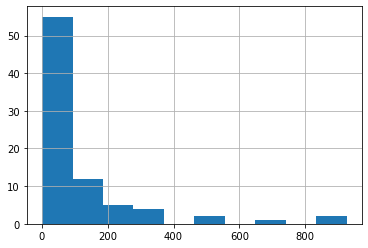

In [18]:
fa_recent[fa_recent['Asset Code'].isin(full_df['index'])]['Duration'].hist()